In [54]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os 

In [55]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [56]:
Pressure = [100, 75, 65, 55, 40, 30] # hPa
Height   = [16,  18, 19, 20, 22, 24] # km

Season = ["Winter", "Spring", "Summer", "Autumn"]

In [57]:
N_head = 5 # first 5 lines are head lines, not include data
N_column = 4 + 2

# Nx = 36
# Ny = 21
# Nz = 5
# N_parcel = 3780

Nx = 24
Ny = 21
Nz = 6
N_parcel = Nx*Ny*Nz

if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')
    

directory = './Lifetime/'
filename = "Lifetime_"+Years[0]+Months[0]+Days[0]+".txt"
print(directory+filename)

./Lifetime/Lifetime_20000101.txt


In [58]:
N_year  = len(Years)
N_month = len(Months)
N_day   = len(Days)

lifetime   = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_N = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_S = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lon = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lat = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lev = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

lifetime.shape

(6, 21, 24, 10, 12, 10)

In [59]:
for i_year in range(N_year):
    for i_month in tqdm(range(N_month)):
        for i_day in range(N_day):
            directory = './Lifetime/'
            filename = "Lifetime_"+Years[i_year]+Months[i_month]+Days[i_day]+".txt"
            File = open(directory+filename, 'r')
        
            Lines = File.readlines()

            # Strips the newline character
            data = []
            data_N = []
            data_S = []
            data_x = []
            data_y = []
            data_z = []
            for line in Lines:
                a = line.split(',')
                data.append(float(a[0])) # total lifetime
                data_N.append(float(a[1])) # total N lifetime
                data_S.append(float(a[2])) # total S lifetime
                data_x.append(float(a[3])) # lon
                data_y.append(float(a[4])) # lat
                data_z.append(float(a[5])) # p
    
            i = 0
            for ix in range(Nx):
                for iy in range(Ny):
                    for iz in range(Nz):
                        lifetime[iz,iy,ix,i_day,i_month,i_year]   = data[i]
                        lifetime_N[iz,iy,ix,i_day,i_month,i_year] = data_N[i]
                        lifetime_S[iz,iy,ix,i_day,i_month,i_year] = data_S[i]
                        Lon[iz,iy,ix,i_day,i_month,i_year] = data_x[i]
                        Lat[iz,iy,ix,i_day,i_month,i_year] = data_y[i]
                        Lev[iz,iy,ix,i_day,i_month,i_year] = data_z[i]

                        i = i+1
                        
                        

100%|██████████| 12/12 [00:02<00:00,  4.80it/s]


In [60]:
# season-mean

# lifetime(Nz, Ny, Nx, N_day, N_month, N_year)

lifetime_mon = np.mean(lifetime, axis=(3,5))
lifetime_N_mon = np.mean(lifetime_N, axis=(3,5))
lifetime_S_mon = np.mean(lifetime_S, axis=(3,5))


# lifetime_mon(Nz, Ny, Nx, N_month)
N_season = 4

lifetime_season = np.zeros((Nz, Ny, Nx, N_season))
lifetime_N_season = np.zeros((Nz, Ny, Nx, N_season))
lifetime_S_season = np.zeros((Nz, Ny, Nx, N_season))


# for Winter
lifetime_season[:,:,:,0]   = np.mean(lifetime_mon[:,:,:,[0,1,11]], axis=3)
lifetime_N_season[:,:,:,0] = np.mean(lifetime_N_mon[:,:,:,[0,1,11]], axis=3)
lifetime_S_season[:,:,:,0] = np.mean(lifetime_S_mon[:,:,:,[0,1,11]], axis=3)
    
# for Spring, Summer and Autumn
for i in range(1,N_season):
    print(i,i*3-1,(i+1)*3-1)
    lifetime_season[:,:,:,i]   = np.mean(  lifetime_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    lifetime_N_season[:,:,:,i] = np.mean(lifetime_N_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    lifetime_S_season[:,:,:,i] = np.mean(lifetime_S_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    
lifetime_season.shape

1 2 5
2 5 8
3 8 11


(6, 21, 24, 4)

In [61]:
D_lifetime_uniform = lifetime_N_season[:,:,:,:] - lifetime_S_season[:,:,:,:]

In [77]:
# LP solver

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html

# (Nz, Ny, Nx, N_season)
Result_season  = lifetime_season[0,:,:,:]*0.0
Lifetime_LP    = lifetime_season[:,:,:,:]*0.0
Lifetime_LP_N  = lifetime_season[:,:,:,:]*0.0
Lifetime_LP_S  = lifetime_season[:,:,:,:]*0.0
D_lifetime_LP  = lifetime_season[:,:,:,:]*0.0

iz = 1

Diff_NS = 0.01

# for LP solve: max lifetime under the interhemispheric balance
for iz in range(Nz):
    print(iz)
    for iseason in range(N_season):
        Life   = lifetime_season[iz,:,:,iseason].flatten()
        Life_S = lifetime_N_season[iz,:,:,iseason].flatten()
        Life_N = lifetime_S_season[iz,:,:,iseason].flatten()

        if sum(Life_S)+sum(Life_N)-sum(Life)>0.01: print("ERROR!!!")
    
        N = len(Life)

        #
        c = -1*Life

        Xs_bounds = []
        A1 = []
        A3 = []
        A4 = []
        A  = []
        for i in range(N):
            Xs_bounds.append((0, N))
            A1.append(1)
            A3.append( Life_N[i] -Life_S[i] -Diff_NS*Life[i] )
            A4.append( -1*(Life_N[i] -Life_S[i] +Diff_NS*Life[i]) )

        Aub = [A3,A4]
        Aeq = [A1]   

        b_ub = [0,0]
        b_eq = [N]

        from scipy.optimize import linprog
        res = linprog(c, A_eq=Aeq, b_eq=b_eq, A_ub=Aub, b_ub=b_ub, bounds=Xs_bounds)
    
        # post-process, calculate the injection percentage
        Result1d = np.round(res.x)
        Result2d = Result1d.reshape(Ny,Nx)
        Result2d = Result2d/np.sum(Result2d)*100
    
        Result_season[:,:,iseason] = Result2d
    
    Lifetime_LP[iz,:,:,:] = lifetime_season[iz,:,:,:]* (Result_season/100)

    Lifetime_LP_N[iz,:,:,:] = lifetime_N_season[iz,:,:,:]* (Result_season/100)
    Lifetime_LP_S[iz,:,:,:] = lifetime_S_season[iz,:,:,:]* (Result_season/100)
    D_lifetime_LP[iz,:,:,:] = Lifetime_LP_N[iz,:,:,:] - Lifetime_LP_S[iz,:,:,:]

print(lifetime_season[:,:,:,:].shape, Result_season.shape)


0
1
2
3
4
5
(6, 21, 24, 4) (21, 24, 4)


In [78]:
# get max lifetime by only selecting LAT (averaged over all LON)

lifetime_season_Xmean   = np.mean(lifetime_season, axis=2)
lifetime_N_season_Xmean = np.mean(lifetime_N_season, axis=2)
lifetime_S_season_Xmean = np.mean(lifetime_S_season, axis=2)
print(lifetime_season_Xmean.shape)

Inject_percent    = np.zeros((Nz, Ny, N_season))
Lifetime_MaxLat   = np.zeros((Nz, Ny, N_season))
Lifetime_MaxLat_N = np.zeros((Nz, Ny, N_season))
Lifetime_MaxLat_S = np.zeros((Nz, Ny, N_season))
D_lifetime_MaxLat = np.zeros((Nz, Ny, N_season))
print(Inject_percent.shape)

for iz in range(Nz):
    for i_season in range(N_season):
        a   = np.mean(lifetime_season[iz,:,:,i_season], axis=1)
        idx = np.unravel_index(np.argmax(a, axis=None), a.shape)
#         print(iz,idx[0],i_season)
        Inject_percent[iz,idx[0],i_season] = 100


    Lifetime_MaxLat[iz,:,:] = lifetime_season_Xmean[iz,:,:]* (Inject_percent[iz,:,:]/100)

    Lifetime_MaxLat_N[iz,:,:] = lifetime_N_season_Xmean[iz,:,:]* (Inject_percent[iz,:,:]/100)
    Lifetime_MaxLat_S[iz,:,:] = lifetime_S_season_Xmean[iz,:,:]* (Inject_percent[iz,:,:]/100)
    D_lifetime_MaxLat[iz,:,:] = Lifetime_MaxLat_N[iz,:,:] - Lifetime_MaxLat_S[iz,:,:]

(6, 21, 4)
(6, 21, 4)


In [79]:
# get the max lifetime by selecting both LON and LAT

Inject_percent = np.zeros((Nz, Ny, Nx, N_season))
Lifetime_max   = np.zeros((Nz, Ny, Nx, N_season))
Lifetime_max_N = np.zeros((Nz, Ny, Nx, N_season))
Lifetime_max_S = np.zeros((Nz, Ny, Nx, N_season))
D_lifetime_max = np.zeros((Nz, Ny, Nx, N_season))

print(Inject_percent.shape)

for iz in range(Nz):
    for i_season in range(N_season):
        a   = lifetime_season[iz,:,:,i_season]
        # Converts a flat index or array of flat indices into a tuple of coordinate arrays
        idx = np.unravel_index(np.argmax(a, axis=None), a.shape) 
#         print(iz,idx[0],idx[1],i_season)
        Inject_percent[iz,idx[0],idx[1],i_season] = 100


    Lifetime_max[iz,:,:,:] = lifetime_season[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)

    Lifetime_max_N[iz,:,:,:] = lifetime_N_season[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)
    Lifetime_max_S[iz,:,:,:] = lifetime_S_season[iz,:,:,:]* (Inject_percent[iz,:,:,:]/100)
    D_lifetime_max[iz,:,:,:] = Lifetime_max_N[iz,:,:,:] - Lifetime_max_S[iz,:,:,:]
    

(6, 21, 24, 4)


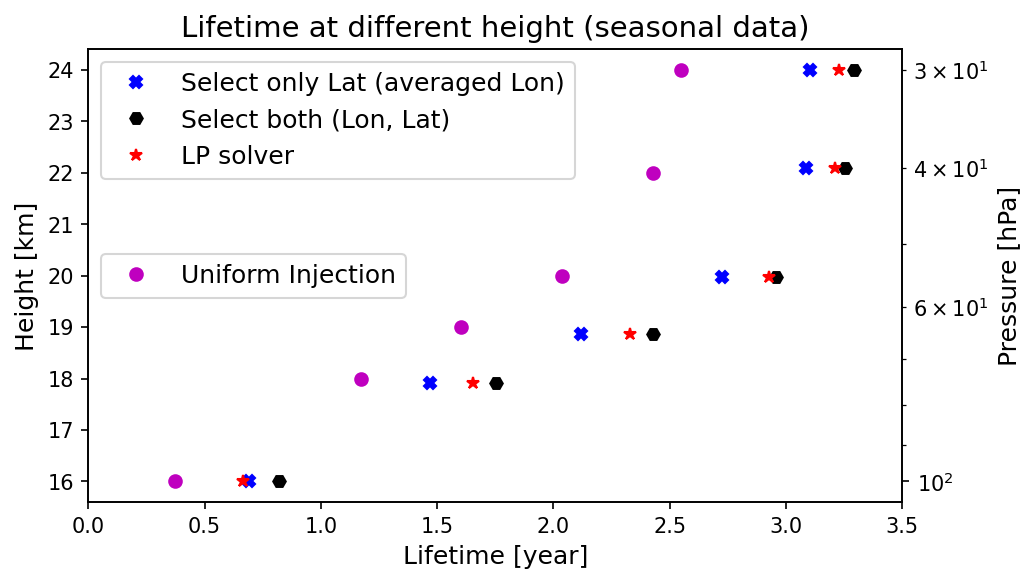

In [80]:
Life_LP_season = np.sum(Lifetime_LP[:,:,:,:], axis=(1,2))/365.25
Life_MaxLat_season = np.sum(Lifetime_MaxLat[:,:,:], axis=(1))/365.25
Life_max_season = np.sum(Lifetime_max[:,:,:,:], axis=(1,2))/365.25
Life_uniform_season = np.mean(lifetime_season[:,:,:,:],axis=(1,2))/365.25

Life_LP_z  = np.mean(Life_LP_season[:,:],axis=1)
Life_MaxLat_z = np.mean(Life_MaxLat_season[:,:],axis=1)
Life_max_z = np.mean(Life_max_season[:,:],axis=1)
Life_uniform_z = np.mean(Life_uniform_season[:,:],axis=1)

### plot
fig, ax1 = plt.subplots(figsize=(7,4), dpi=150)

###
ax1.plot(Life_uniform_z, Height, 'mo', label='Uniform Injection')

ax1.set_xlim(0,3.5)

ax1.set_xlabel('Lifetime [year]', fontsize=12)
ax1.set_ylabel('Height [km]', fontsize=12)
ax1.legend(loc='center left', fontsize=12);

###
ax2 = ax1.twinx()
ax2.plot(Life_MaxLat_z, Pressure, 'bX', label='Select only Lat (averaged Lon)')
ax2.plot(Life_max_z, Pressure, 'kH', label='Select both (Lon, Lat)')
ax2.plot(Life_LP_z, Pressure, 'r*', label='LP solver')

ax2.set_ylabel('Pressure [hPa]', fontsize=12)
ax2.set_yscale('log')
ax2.invert_yaxis()
ax2.legend(loc="upper left", fontsize=12);

###
# ax3 = ax1.twinx()
# ax3.plot(Life_LP_z, Pressure, 'b*', label='LP solver lifetime')

# ax3.set_ylabel('Pressure [hPa]', fontsize=12)
# ax3.set_yscale('log')
# ax3.invert_yaxis()
# ax3.legend(loc="upper left", fontsize=12);


plt.title('Lifetime at different height (seasonal data)', fontsize=14);

In [86]:

Life_max_AllMean = np.mean(Life_max_z)
Life_LP_AllMean = np.mean(Life_LP_z)
Life_MaxLat_AllMean = np.mean(Life_MaxLat_z)
Life_uniform_AllMean = np.mean(Life_uniform_z)

Life_max_AllMean, Life_LP_AllMean, Life_MaxLat_AllMean, Life_uniform_AllMean

(2.4178644763860366, 2.3356877733474817, 2.1994977754962353, 1.693630963698127)

In [82]:
D_lifetime_LP.shape, D_lifetime_max.shape, D_lifetime_MaxLat.shape, D_lifetime_uniform.shape

((6, 21, 24, 4), (6, 21, 24, 4), (6, 21, 4), (6, 21, 24, 4))

In [83]:
# use np.sum if a injection percent is applied to the variable before

D_lifetime_LP_XYmean      = np.sum(D_lifetime_LP, axis=(1,2))
D_lifetime_MaxLat_XYmean  = np.sum(D_lifetime_MaxLat, axis=(1))
D_lifetime_max_XYmean     = np.sum(D_lifetime_max, axis=(1,2))
D_lifetime_uniform_XYmean = np.mean(D_lifetime_uniform, axis=(1,2))

D_lifetime_LP_XYmean.shape, D_lifetime_max_XYmean.shape, D_lifetime_MaxLat_XYmean.shape, D_lifetime_uniform_XYmean.shape

((6, 4), (6, 4), (6, 4), (6, 4))

In [84]:
print(np.mean(abs(D_lifetime_LP_XYmean), axis=1))
print(np.mean(abs(D_lifetime_max_XYmean), axis=1))
print(np.mean(abs(D_lifetime_MaxLat_XYmean), axis=1))
print(np.mean(abs(D_lifetime_uniform_XYmean), axis=1))

[ 2.50229497  5.97057705  8.38099868 10.4778621  11.71878307 11.89074735]
[211.4125     243.75666667 158.7725     146.86       269.21083333
 396.36916667]
[186.85305556 184.46006944 210.7746875  154.93194444 205.99201389
 292.67024306]
[20.72166005 33.232958   34.07718254 23.45626984 20.20613922 36.78309689]


In [85]:
print(np.mean(abs(D_lifetime_LP_XYmean), axis=(0,1))/365.25)
print(np.mean(abs(D_lifetime_max_XYmean), axis=(0,1))/365.25)
print(np.mean(abs(D_lifetime_MaxLat_XYmean), axis=(0,1))/365.25)
print(np.mean(abs(D_lifetime_uniform_XYmean), axis=(0,1))/365.25)

0.023244929604158453
0.650870028139022
0.5638521623951124
0.07687762105754918
